In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.Align import substitution_matrices
matrix_b90 = substitution_matrices.load("BLOSUM90")
import array

In [7]:
matched_motifs = pd.read_csv("OocyteMat_HumanMatch_01192022_v2.csv",dtype={"Human_Residue":str})
matched_motifs.head()

,Xenopus_Reference,Human_Reference,Match_Code,Xen_Residue,Human_Residue,Xen_Motif,Human_Motif
0,gnl|gene10006|XL-9_2-gene10006|rna29084|,GN:SUPT16H|SPT16|human|Q9Y5B9,0,1006,1017,RKADRESLYEEVE,EQSRSMSRKRKAS
1,gnl|gene10015|XL-9_2-gene10015|rna29109|,GN:ATPIF1|ATPIF1|human|Q9UII2,0,24,27,MQMRRSSDQLGEL,QARGFGSDQSENV
2,gnl|gene10020|XL-9_2-gene10020|rna29121|,GN:PHAX|RNUXA|human|Q9H814,0,393,364,TNEALASLDDEHT,TNEALASLDESQE
3,gnl|gene10020|XL-9_2-gene10020|rna29121|,GN:PHAX|RNUXA|human|Q9H814,0,414,388,AIEIDNSHDLETF,AIEVDHSHDLDIF
4,gnl|gene10028|XL-9_2-gene10028|rna29144|,GN:PPM1G|PPM1G|human|O15355,-1,222,222,NaN,NaN


In [8]:
num_match = sum(matched_motifs['Match_Code']==0)
num_match_swap = sum(matched_motifs['Match_Code']==1)
num_match_nopres = sum(matched_motifs['Match_Code']==3)
num_match_gap = sum(matched_motifs['Match_Code']==-1)
num_match_noalign = sum(matched_motifs['Match_Code']==-2)
num_match_nohuman = sum(matched_motifs['Match_Code']==-3)
total_num = len(matched_motifs)

match_results_count = [num_match_nohuman, num_match_noalign, num_match_gap, num_match_nopres, num_match_swap, num_match]
match_results_frac = [match_results_count[i]/total_num for i in range(len(match_results_count))]



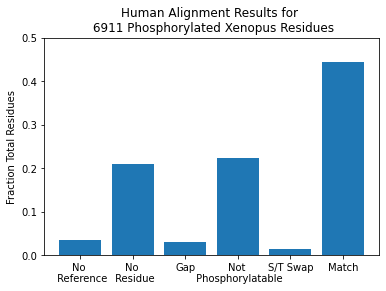

In [12]:
fig, ax = plt.subplots()
ax.bar([i for i in range(len(match_results_frac))], match_results_frac)
ax.set_xticks([i for i in range(len(match_results_frac))])
ax.set_yticks([i/10 for i in range(6)])
ax.set_xticklabels(["No \n Reference","No \n Residue","Gap", "Not \n Phosphorylatable", "S/T Swap","Match"])
ax.set_ylabel("Fraction Total Residues")
ax.set_title("Human Alignment Results for \n {} Phosphorylated Xenopus Residues".format(total_num))
plt.show()
fig.savefig("Alignment_Results_Histogram_0117922.eps", bbox_inches='tight')



In [9]:
print("[{} residues are on a reference that does not have a human match]".format(num_match_nohuman))
print("{} residues align to the same phosphorylatable residue".format(num_match))
print("{} residues align to an S/T swap".format(num_match_swap))
print("{} residues align to a non-phosphorylatable residue".format(num_match_nopres))
print("{} residues align to a gap on a human reference.".format(num_match_gap))
print("{} residues are in a region that does not align to the human reference.".format(num_match_noalign))
print("{} percent of residues on references that have human matches align to a phosphorylatable residues."\
     .format(round(((num_match+num_match_swap)/total_num)*100,2)))


[244 residues are on a reference that does not have a human match]
3067 residues align to the same phosphorylatable residue
91 residues align to an S/T swap
1551 residues align to a non-phosphorylatable residue
202 residues align to a gap on a human reference.
1453 residues are in a region that does not align to the human reference.
45.7 percent of residues on references that have human matches align to a phosphorylatable residues.


In [11]:
def score_align(xen_in, hs_in, match_x, mismatch_x, matrix_b90):
    import numpy as np
    
    return_info = np.zeros((3,2))
    
    ind_f = (0, 12)
    
    for i in range(len(ind_f)):
        
        which_way = ind_f[i]
    
        #for j in range(len(xen_m)):
        for j in [0,1,2,3,4,5,7,8,9,10,11,12]:
        
            k = abs(j-which_way)
            
            if (xen_in[j] != "x" and xen_in[k] != "x" and hs_in[j] != "x" and hs_in[k] != "x"):
                
                return_info[2,i] += matrix_b90[xen_in[j]][hs_in[k]]
                return_info[0,i] += matrix_b90[xen_in[j]][xen_in[k]]
                return_info[1,i] += matrix_b90[hs_in[j]][hs_in[k]]
          
            elif (xen_in[j] == "x" and xen_in[k] == "x" and hs_in[j] == "x" and hs_in[k] == "x"):
            
                return_info[2,i] += match_x
                return_info[0,i] += match_x
                return_info[1,i] += match_x
        
            elif ((xen_in[j] == "x" and xen_in[k] == "x") and (hs_in[j] != "x" and hs_in[k] != "x")):

                return_info[2,i] += mismatch_x
                return_info[0,i] += match_x
                return_info[1,i] += matrix_b90[hs_in[j]][hs_in[k]]
        
            elif ((xen_in[j] != "x" and xen_in[k] != "x") and (hs_in[j] == "x" and hs_in[k] == "x")):
                
                return_info[2,i] += mismatch_x
                return_info[0,i] += match_x
                return_info[1,i] += matrix_b90[xen_in[j]][xen_in[k]]
    
    return return_info

matched_motifs_F = matched_motifs[matched_motifs["Match_Code"]>=0]
store_score = []

match_x = (np.diag(matrix_b90)).mean()
store_mm_vals = []

for i in range(len(matrix_b90)):
    for j in range(1,i):
        store_mm_vals.append(matrix_b90[i][j])

mismatch_x = np.mean(store_mm_vals)

for i in range(len(matched_motifs_F)):
    xen_m = (matched_motifs_F.iloc[i,5])
    hs_m = (matched_motifs_F.iloc[i,6])
    
    return_info = score_align(xen_m, hs_m, match_x, mismatch_x, matrix_b90)
    f_best = max(return_info[:,0])
    f_worst = min(return_info[:,1])
    store_score.append(round((return_info[2,0] - f_worst)/(f_best - f_worst),2))
    
store_score_pd = pd.DataFrame(store_score)
matched_motifs_F = matched_motifs_F.assign(Motif_Score = store_score_pd.values)


In [12]:
matches_only = matched_motifs_F[matched_motifs_F["Match_Code"]<3]
#print(np.mean(matches_only["Motif_Score"]))

[m_counts,bins] = np.histogram(matches_only["Motif_Score"], bins= [i/20 for i in range(21)])
match_h = np.histogram(matches_only["Motif_Score"], bins= [i/20 for i in range(21)])

mmatches_only = matched_motifs_F[matched_motifs_F["Match_Code"]==3]
#np.mean(mmatches_only["store_score_pd"])

[mm_counts,bins] = np.histogram(mmatches_only["Motif_Score"], bins= [i/20 for i in range(21)])

fraction_m = [round(mm_counts[i]/(m_counts[i]+mm_counts[i]),2) for i in range(len(m_counts))]
FDR_atcutoff = [round(sum(mm_counts[i:])/(sum(m_counts[i:])+sum(mm_counts[i:])),3)*100 for i in range(len(m_counts))]


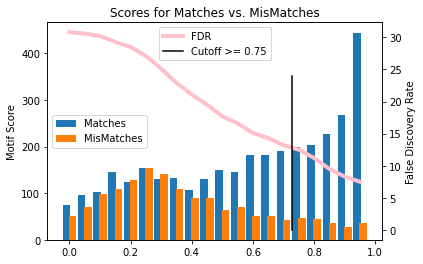

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [18]:
# make a plot of the distribution of scores for phosphorylateable matches vs not phosphorylatable
# and also include the FDR rate as a line

width = 0.025  # the width of the bars
fig, ax = plt.subplots()

ax.bar(x = bins[:len(bins)-1]-width/2.5, height = m_counts, width = 0.025, label='Matches')
ax.bar(x = bins[:len(bins)-1]+width/2.5, height = mm_counts, width = 0.025, label='MisMatches')

ax2 = ax.twinx()
ax2.plot(bins[:len(bins)-1], FDR_atcutoff, color = "pink", label = "FDR", linewidth = '4')
ax2.plot([bins[15]-2.2*width/2.5 for i in range(25)],[i for i in range(25)], color = "black",\
         label = "Cutoff >= 0.75")

ax2.set_ylabel('False Discovery Rate')
ax2.legend(loc = "upper center")

ax.set_ylabel('Motif Score')
ax.set_title('Scores for Matches vs. MisMatches')
ax.legend(loc="center left")

plt.show()

fig.savefig("MotifScoreHistogram_wFDR_011922.eps", bbox_inches='tight')


In [13]:
matched_motifs_keep = \
matched_motifs_F[(matched_motifs_F["Match_Code"] <= 1) & (matched_motifs_F["Motif_Score"] >= 0.75)]
matched_motifs_keep.to_csv("Matched_Filtered0p75_012022.csv", index = False)